In [34]:
import scipy as sp
import scipy.linalg as spla
import scipy.optimize as spopt
import scipy.stats as spst

import numpy as np
import numpy.linalg as npla

import statsmodels as sm
import statsmodels.api as sma

smfOLS = sma.regression.linear_model.OLS.from_formula
smfLGT = sm.discrete.discrete_model.Logit.from_formula
smfPRB = sm.discrete.discrete_model.Probit.from_formula

import seaborn as sb
import pandas as pd

import matplotlib.pyplot as plt

from inspect import signature as sig

In [35]:
# matplotlib image size and resolution
mpl_options = {"figsize":(8,8), "dpi":100}
sb.set(rc={'figure.figsize':(8,8)})

# Part 4. Support Vector machine

In [36]:
means = np.array([0,0])
covs = np.eye(2)
means, covs

(array([0, 0]),
 array([[1., 0.],
        [0., 1.]]))

In [79]:
size = 500
sample = np.random.multivariate_normal(means, covs, size=size)

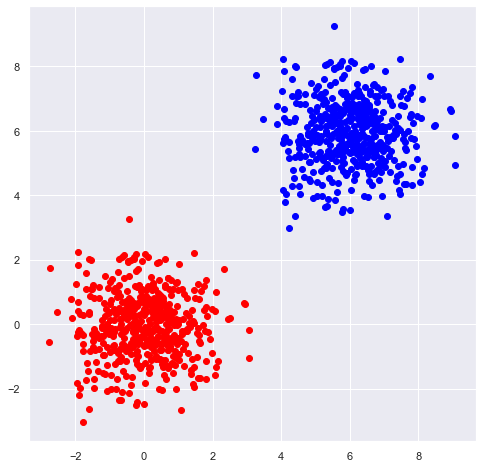

In [80]:
plt.scatter(sample[:,0], sample[:,1], color = 'red')
plt.scatter(sample[:,0]+6, sample[:,1]+6, color = 'blue')

### Давайте вместо того чтобы сравнивать $\log \frac{1}{1+\exp(-z)}$ с 0 как пороговый уровень, попробуем сравнить его с +1 и - 1? То есть, будем считать что когда скор z достаточно большой (>1) мы выбираем синюю альтернативу, когда он маленький (<-1) мы выбираем красную альтернативу, а в интервале [-1,1] мы как бы не выбираем ничего. Тогда доли в Лайклихуде будут устроены несколько иначе:

$$ Utility = \sum_{y_i = 1} \log F(z-1) + \sum_{y_i = -1} \log F(-z-1) \to \max_{\beta}$$
### Это некоторая модификация логита, и у него даже есть экономическая интерпретация: человек выбирает альтернативу только когда он "по настоящему уверен". Я не знаю его популярное название, но будем называть его "уверенный Логит" на всякий случай. Это приятная, выпуклая задача.

### Единственная проблема это параметр ширины окна (мы выставили его равный 2), который придется кроссвалидировать, иначе его невозможно отделить от дисперсии ошибки.

# Теперь про SVM

### Есть еще один способ, чем то похожий на то что мы сейчас сделали, это SVM. Он бывает двух типов:
- hard margin SVM
- soft margin SVM

### Hard margin SVM выбирает коэффициенты так, чтобы между облаками можно было вставить слой максимальной толщины. Сам классификатор работает как сигнум фунцкия на скоре (чем то похоже на сигмоиду логита, но негладкая): 

$$ x \to \hat y = sgn(\alpha + \beta ' x) \in \{-1,1\}$$

### Как выбрать размер окна? Давайте максимизировать размер окна
### Так как толщина слоя это $\frac{2}{||\beta||}$, задача оптимизации имеет следующий вид: 
$$ ||\beta|| \to \min, \quad s.t. \quad y_i (\alpha + \beta' x) \geqslant 1$$

### Soft margin SVM делает все то же самое, но позволяет нескольким наблюдениям провалиться внутрь слоя, за что, конечно надо будет заплатить в Loss функции, иначе они все туда провалятся

### Задача оптимизации имеет следующий вид:
$$ ||\beta||+C \sum \xi_i \to \min, \quad s.t. \quad y_i (\alpha + \beta' x) \geqslant 1 - \xi_i$$

### Два важных факта:
- вся задача очевидно выпуклая
- параметр $\alpha$ определяется внутри модели, его не надо кроссвалиидировать
- параметр $C$ определяется снаружи модели, его НАДО кроссвалиидировать

### Так как задача выпуклая, там можно применять Метод Лагранжа, но, так как это типично происходит в ОЧЕНЬ больших размерностях, детали поиска седловой точки Лагранжиана я рассказывать не буду, а вместо этого посмотрим готовый интерфейс в Питоне.

In [81]:
df = pd.DataFrame([])
df['X1']=np.hstack((sample[:,0], sample[:,0]+6))
df['X2']= np.hstack((sample[:,1], sample[:,1]+6))
df['Y'] = np.hstack((np.zeros(size), np.ones(size)))
df

,X1,X2,Y
0,1.001423,0.007419,0.0
1,-0.228359,-0.168150,0.0
2,-0.159861,-0.449284,0.0
3,-2.736543,1.726471,0.0
4,-1.029447,0.366983,0.0
...,...,...,...
995,6.492402,5.240806,1.0
996,7.220702,5.786074,1.0
997,6.665605,6.202506,1.0
998,4.559803,5.202214,1.0


In [95]:
from sklearn import svm
clf = svm.SVC(kernel='linear', verbose=True)

#clf?
from inspect import signature

In [96]:
signature(svm.SVC)

<Signature (*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)>

In [97]:
X = df[['X1','X2']].values
Y = df['Y'].values

svc = clf.fit(X, Y)
signature(clf.fit)

[LibSVM]

<Signature (X, y, sample_weight=None)>

In [ ]:
plt.scatter(sample[:,0], sample[:,1], color = 'orange', s = 12)
plt.scatter(sample[:,0]+6, sample[:,1]+6, color = 'green', s = 12)

points = np.vstack((np.random.uniform(-2,8,1000),np.random.uniform(-2,8,1000))).T

for point in points:

    pred = int(svc.predict([point])[0])
    if pred == 0:
        plt.scatter(point[0], point[1], color = 'red', s = 10)
    else:
        plt.scatter(point[0], point[1], color = 'blue', s = 10)

### Посмотрим на собственно саппорт вектора - это точки убрав которые вы измените классификатор.

In [ ]:
plt.scatter(sample[:,0], sample[:,1], color = 'orange', s = 12)
plt.scatter(sample[:,0]+6, sample[:,1]+6, color = 'green', s = 12)

points = clf.support_vectors_

for point in points:

    pred = int(svc.predict([point])[0])
    if pred == 0:
        plt.scatter(point[0], point[1], color = 'red', s = 50)
    else:
        plt.scatter(point[0], point[1], color = 'blue', s = 50)

# Какая тут мораль?
- если облака погружены сильно, можно делать логит
- если облака погружены слабо, можно делать мягкий свм
- если облака разделены совсем, можно делать жесткий свм или уверенный логит